# Analysis: XGBoost for Profitability

Goal: Use XGBoost to create a model classifying the profitable feature.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline;

Using TensorFlow backend.


In [2]:
%load_ext autoreload

import sys
sys.path.append('../')
import plot_confusion_matrix as pcm;

## Prepare Target & Features

In [3]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = pd.read_csv(FEATURE_FILE)

In [4]:
drop_category_nmbr_cnts = [s for s in list(full_df.columns) if '_cnt_prts' in s]
len(drop_category_nmbr_cnts)

57

In [5]:
# drop volume and weight since they are sparse and colinear,
# drop arbitrary details set_no, name,
# drop price data used to create the target,
# drop popularity because it reflects future perception not time of purchase info.

full_df.drop(columns=['set_no', 'name',  'price_store', 'price_used',
                      'volume', 'weight', 'total_parts','number_spare_parts',
                      'popularity', 'aftermarket', 'adj_store_price',
                      'adj_aftermarket']+drop_category_nmbr_cnts,
             inplace=True)

# filter out rows without profitable (i.e. target), and the few without primary/secondary colors
full_df.dropna(axis=0,
               subset=['profitable', 'scolor_1st', 'scolor_2nd'],
               inplace=True)

full_df.head()

,year,number_parts,total_spare_parts,number_colors,bars_ladders_and_fences_tot_prts,baseplates_tot_prts,belville_scala_and_fabuland_tot_prts,bionicle_hero_factory_and_constraction_tot_prts,bricks_tot_prts,bricks_curved_tot_prts,...,transportation_-_sea_and_air_tot_prts,tubes_and_hoses_tot_prts,wheels_and_tyres_tot_prts,windows_and_doors_tot_prts,windscreens_and_fuselage_tot_prts,znap_tot_prts,category,scolor_1st,scolor_2nd,profitable
4,1984,30,0,7,2,1,8,0,21,2,...,0,0,0,3,0,0,Bigfig-Junior,Yellow,Red,1.0
5,1984,34,2,8,2,1,6,0,8,0,...,3,0,0,7,0,0,Bigfig-Junior,Yellow,Red,1.0
8,1984,26,0,8,0,0,0,0,1,0,...,0,0,2,0,0,0,Historical,Black,Red,1.0
9,1984,30,4,8,0,0,0,0,2,0,...,0,0,0,0,0,0,Historical,Black,Blue,1.0
10,1984,30,0,7,0,0,0,0,6,0,...,0,0,2,0,0,0,Historical,Black,Red,1.0


In [6]:
full_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3824 entries, 4 to 4921
Data columns (total 65 columns):
year                                                3824 non-null int64
number_parts                                        3824 non-null int64
total_spare_parts                                   3824 non-null int64
number_colors                                       3824 non-null int64
bars_ladders_and_fences_tot_prts                    3824 non-null int64
baseplates_tot_prts                                 3824 non-null int64
belville_scala_and_fabuland_tot_prts                3824 non-null int64
bionicle_hero_factory_and_constraction_tot_prts     3824 non-null int64
bricks_tot_prts                                     3824 non-null int64
bricks_curved_tot_prts                              3824 non-null int64
bricks_printed_tot_prts                             3824 non-null int64
bricks_round_and_cones_tot_prts                     3824 non-null int64
bricks_sloped_tot_prts       

In [7]:
# target series
target = full_df['profitable']
print(target.shape)

# initial features
features = full_df.drop(columns=['profitable'])
print(features.shape)

(3824,)
(3824, 64)


In [8]:
# feature dataframe with one-hot encoding

features = pd.get_dummies(features, drop_first= True,
                          columns=['category', 'scolor_1st', 'scolor_2nd'])
features.shape

(3824, 92)

## Train-Test Split & Standardize

In [9]:
TEST_SPLIT = 0.2
SEED = 0

In [10]:
y_train, y_test, X_train, X_test = train_test_split(target, features,
                                                    stratify=features['year'],
                                                    test_size=TEST_SPLIT, random_state=SEED)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(3059,)
(765,)
(3059, 92)
(765, 92)


In [11]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

## PCA Analysis

In [12]:
# Initial full PCA of features
pca = PCA(random_state=SEED)
x_pca = pca.fit_transform(X_train_std)

In [13]:
# exploring explained variance
len(pca.explained_variance_ratio_)

92

In [14]:
# defining count of PCA features to capture 99% of variance
PCA_COUNT = sum(pca.explained_variance_ratio_.cumsum() < .95) + 1
print(PCA_COUNT)
PCA_EXPLAINED_VAR = pca.explained_variance_ratio_.cumsum()[PCA_COUNT-1]
print(PCA_EXPLAINED_VAR)

66
0.9522254515489256


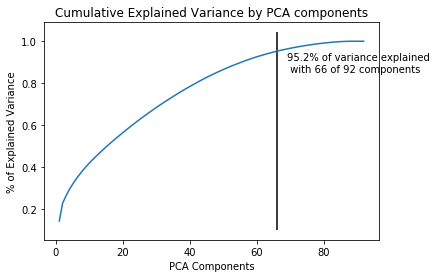

In [15]:
# plotting PCA cumulative explained variance.
# plenty of dimension reduction will be possible,
# which will allow the model to perform more quickly,
# particularlly during GridSearchCV
feat_cnt = X_train.shape[1]
plt.plot(range(1,feat_cnt+1), pca.explained_variance_ratio_.cumsum())

ax = plt.gca()
ax.set_xlabel("PCA Components")
ax.set_ylabel("% of Explained Variance")
ax.set_title("Cumulative Explained Variance by PCA components")

ax.vlines(x=PCA_COUNT, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
ax.annotate(f'{round(100*PCA_EXPLAINED_VAR,1)}% of variance explained \n with {PCA_COUNT} of {feat_cnt} components',
            xy=[PCA_COUNT, PCA_EXPLAINED_VAR],
            xytext=[PCA_COUNT+3, PCA_EXPLAINED_VAR-0.1]);

## GridSearchCV with XGBoost and Pipeline of Scaling and PCA

In [16]:
pca_pipe = Pipeline([("scaler", StandardScaler()),
                     ("pca", PCA(n_components=PCA_COUNT, random_state=SEED)),
                     ("xgb", XGBClassifier(random_state=SEED))])

class_pos_rate = y_train.value_counts()[0] / y_train.value_counts()[1]
param_grid = {"xgb__learning_rate": [0.1],
              'xgb__max_depth': [3, 6],
              'xgb__min_child_weight': [1, 3],
              'xgb__subsample': [0.75, 1],
              'xgb__n_estimators': [100, 150, 200]}

clf = XGBClassifier(scale_pos_weight=class_pos_rate)
grid_clf = GridSearchCV(pca_pipe, param_grid, scoring='accuracy', cv=3)

In [17]:
grid_clf.fit(X_train, y_train);

In [18]:
grid_clf_results = pd.DataFrame(grid_clf.cv_results_)

In [19]:
grid_clf_results.mean_test_score.describe()

count    24.000000
mean      0.768497
std       0.002915
min       0.763975
25%       0.765937
50%       0.768388
75%       0.770513
max       0.775090
Name: mean_test_score, dtype: float64

In [20]:
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 3
xgb__min_child_weight: 1
xgb__n_estimators: 200
xgb__subsample: 0.75

Training Accuracy: 90.13%


## GridSearchCV with XGBoost and Pipeline of Scaling, PCA and SMOTE Oversampling

In [21]:
smote_pca_pipe = Pipeline([("scaler", StandardScaler()),
                           ("smote", SMOTE(random_state=SEED)),
                           ("pca", PCA(n_components=PCA_COUNT, random_state=SEED)),
                           ("xgb", XGBClassifier(random_state=SEED))])

param_grid = {"xgb__learning_rate": [0.1],
              'xgb__max_depth': [3, 6],
              'xgb__min_child_weight': [1, 3],
              'xgb__subsample': [0.75, 1],
              'xgb__n_estimators': [100, 150, 200]}

smote_grid_clf = GridSearchCV(smote_pca_pipe, param_grid, scoring='accuracy', cv=3)

In [22]:
smote_grid_clf.fit(X_train, y_train);

In [23]:
smote_grid_clf_results = pd.DataFrame(smote_grid_clf.cv_results_)

In [24]:
smote_grid_clf_results.mean_test_score.describe()

count    24.000000
mean      0.739321
std       0.011513
min       0.719516
25%       0.730631
50%       0.739784
75%       0.750327
max       0.753841
Name: mean_test_score, dtype: float64

In [25]:
smote_best_parameters = smote_grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(smote_best_parameters.keys()):
    print("%s: %r" % (param_name, smote_best_parameters[param_name]))

smote_training_preds = smote_grid_clf.predict(X_train)
smote_training_accuracy = accuracy_score(y_train, smote_training_preds)

print("")
print("Training Accuracy: {:.4}%".format(smote_training_accuracy * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 6
xgb__min_child_weight: 1
xgb__n_estimators: 200
xgb__subsample: 0.75

Training Accuracy: 99.74%


## Testing

In [26]:
val_preds = grid_clf.predict(X_test)
val_accuracy = accuracy_score(y_test, val_preds)

smote_val_preds = smote_grid_clf.predict(X_test)
smote_val_accuracy = accuracy_score(y_test, smote_val_preds)

print("")
print("XGBoost w/out SMOTE Validation Accuracy: {:.4}%".format(val_accuracy * 100))
print("")
print("XGBoost w/ SMOTE Validation Accuracy: {:.4}%".format(smote_val_accuracy * 100))
print("")
print("Accuracy Assuming None Profitable: {:.4}%".format(len(y_test[y_test==0]) / len(y_test) * 100))


XGBoost w/out SMOTE Validation Accuracy: 79.35%

XGBoost w/ SMOTE Validation Accuracy: 76.08%

Accuracy Assuming None Profitable: 72.16%


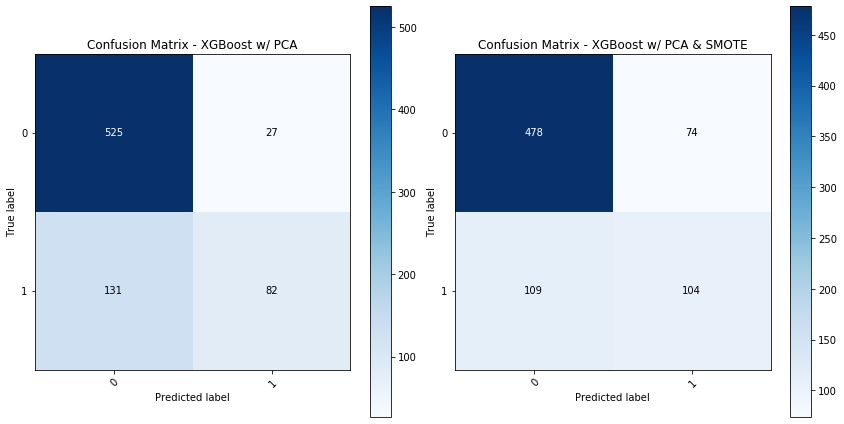

In [27]:
#plotting confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost w/ PCA",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=ax1)

pcm.plot_confusion_matrix(y_test.astype('int64'),
                          smote_val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost w/ PCA & SMOTE",
                          classes=np.array([0,1]),
                          figure=fig,
                          axis=ax2)

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
ax1.set_ylim(1.5, -0.5)
ax2.set_ylim(1.5, -0.5);